## Manipulator Kinematics ##

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle
from IPython.display import display, clear_output
import numpy as np
import cv2
import copy
from numpy import cos, sin, pi, exp
from math import fabs, sqrt
import time
import random
import operator

In [2]:
import sys
sys.path.append("C:/Users/Mafeus/Desktop/Git_Repos/OpenCV")
import OpCV_Utils

In [3]:
import Utils_3D as Ut3D

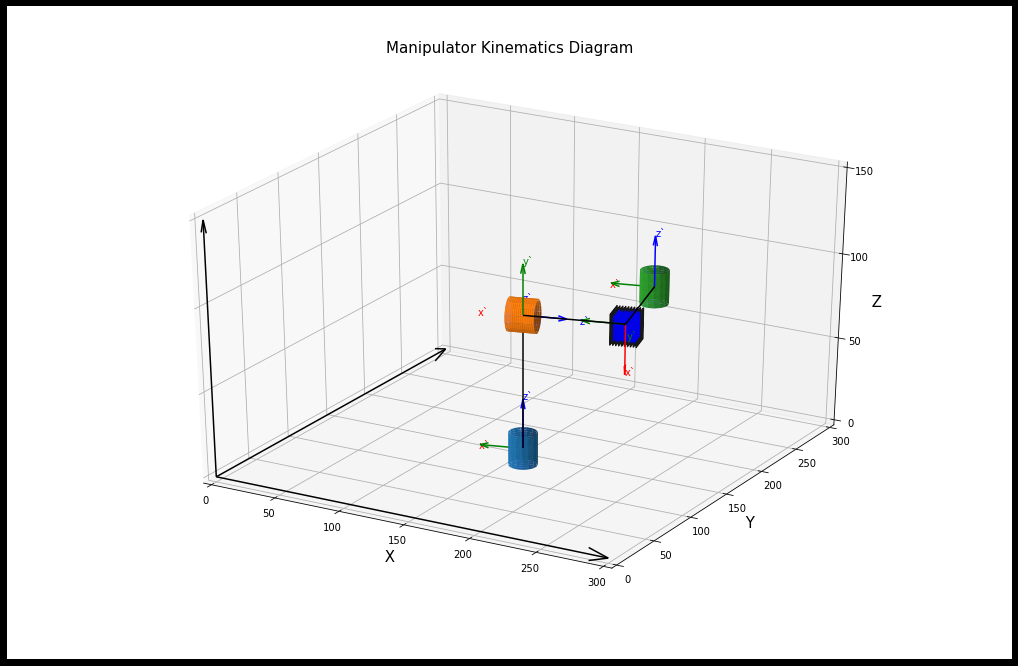

In [176]:
# Graph Properties:
fig = plt.figure(figsize=(18,12), facecolor='k')
ax = fig.add_subplot(111, projection='3d')

for i in range(0, 3600, 15):
    
    start = time.time()
    
    Xmin, Xmax = 0, 300
    Ymin, Ymax = 0, 300
    Zmin, Zmax = 0, 150

    ax.set_xlabel('\n X ', fontsize=15)
    ax.set_ylabel('\n Y ', fontsize=15)
    ax.set_zlabel('\n Z ', fontsize=15)

    ax.set_xticks([0, 50, 100, 150, 200, 250, 300])
    ax.set_yticks([0, 50, 100, 150, 200, 250, 300])
    ax.set_zticks([0, 50, 100, 150])
    ax.dist = 12

    ax.set_xlim([Xmin, Xmax])
    ax.set_ylim([Ymin, Ymax])
    ax.set_zlim([Zmin, Zmax])

    ax.set_title('Manipulator Kinematics Diagram', fontsize=15)

    ax.quiver(Xmin, 0, 0, Xmax, 0, 0, arrow_length_ratio = 0.05, color='k')
    ax.quiver(0, Ymin, 0, 0, Ymax, 0, arrow_length_ratio = 0.05, color='k')
    ax.quiver(0, 0, Zmin, 0, 0, Zmax, arrow_length_ratio = 0.05, color='k')

    # Frame 1:
    F1_orientation = (0,0,0)
    F1_mov_angle   = i
    x, y, z        = 150, 150, 0
    F1_jointType   = 'Revolute Joint'
    
    # Frame 2:
    Link2 = 80
    F2_orientation = (90,0,0)
    F2_mov_angle   = i
    F2_jointType   = 'Revolute Joint'
    
    # Frame 3:
    Link3 = 70
    F3_orientation = (0,90,0)
    F3_mov_angle   = 0
    F3_jointType   = 'Prismatic Joint'
    
    # Frame 4:
    Link4 = 80
    F4_orientation = (0,0,0)
    F4_mov_angle   = 0
    F4_jointType   = 'Revolute Joint'
    
    frameOne   = [x, y, z, F1_orientation, F1_mov_angle, F1_jointType]
    frameTwo   = [Link2, F2_orientation, F2_mov_angle, F2_jointType]
    frameThree = [Link3, F3_orientation, F3_mov_angle, F3_jointType]
    frameFour  = [Link4, F4_orientation, F4_mov_angle, F4_jointType]

    frame_list = [frameOne, frameTwo, frameThree, frameFour]
    
    kinDiagram(ax, frame_list)
    
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

    cv2.imshow("Grid", img)
    
    key = cv2.waitKey(1) or 0xff   
    if key == ord('k'):
        break

    ax.cla()
    
    end = time.time()
    
    # print(start-end)
    
cv2.destroyAllWindows()

In [5]:
def drawLink(ax, x1, y1, z1, x2, y2, z2):
    
    origin = np.array([x1, y1, z1])
    vector = np.array([x2 - x1, y2 - y1, z2 - z1])
    
    X, Y, Z, U, V, W = Ut3D.vec_to_quiver(origin, vector)
    ax.quiver(X, Y, Z, U, V, W, arrow_length_ratio = 0.01, color='k')
    

In [175]:
def kinDiagram(ax, frame_list):
    
    ############################################################################################################
    # Frame One:
    
    frameOne = frame_list[0]
    
    orientation = frameOne[3]
    movement_angle = mov_dir(orientation, frameOne[4])
    
    x, y, z = frameOne[0], frameOne[1], frameOne[2]
    
    if frameOne[5] == 'Revolute Joint':
        
        radius = 10
        height = 20
        
        Ut3D.drawCylinder(ax, x, y, z, radius, height, orientation, movement_angle)
        Ut3D.drawFrameAxis(ax, x, y, z, orientation, movement_angle)
        
    elif frameOne[5] == 'Prismatic Joint':
        
        L = 20
        
        Ut3D.drawCube(ax, x, y, z, L, movement_angle)
        Ut3D.drawFrameAxis(ax, x, y, z, orientation, movement_angle)
        
    else:
        print('Wrong Joint Type Defined.')
        
    ############################################################################################################
    
    for n, frame in enumerate(frame_list):
        
        previous_orientation = (orientation[0], orientation[1], orientation[2])
        previous_mov_angle   = (movement_angle[0], movement_angle[1], movement_angle[2])
        k = (x,y,z); xp = k[0]; yp = k[1]; zp = k[2];        
                
        if (n > 0):
                        
            link_length    = frame[0]
            orientation    = frame[1]            
            
            axis_movement = mov_dir(orientation, frame[2])
            
            LinkArray = linkDirection(previous_orientation, link_length)
                        
            x, y, z = movLink(previous_mov_angle, axis_movement, LinkArray)
                        
            x += xp; y += yp; z += zp;
            
            if frame[3] == 'Revolute Joint':
        
                radius = 10
                height = 20

                Ut3D.drawCylinder(ax, x, y, z, radius, height, orientation, previous_mov_angle)
                Ut3D.drawFrameAxis(ax, x, y, z, orientation, previous_mov_angle)
        
            elif frame[3] == 'Prismatic Joint':

                L = 20

                Ut3D.drawCube(ax, x, y, z, L, previous_mov_angle)
                Ut3D.drawFrameAxis(ax, x, y, z, orientation, previous_mov_angle)
                
            else:
                print('Wrong Joint Type Defined.')
                
            drawLink(ax, xp, yp, zp, x, y, z)
            
                            

In [19]:
def mov_dir(orientation, angle):
    
    if (orientation == (0,0,0)):
        mov_angle = (0,0,angle)
    
    elif (orientation == (90,0,0)):
        mov_angle = (0,-angle,0)
    
    elif (orientation == (-90,0,0)):
        mov_angle = (0,angle,0)
    
    elif (orientation == (0,90,0)):
        mov_angle = (angle,0,0)
    
    elif (orientation == (0,-90,0)):
        mov_angle = (-angle,0,0)
    
    elif (orientation == (0,0,90)):
        mov_angle = (0,0,angle)
    
    elif (orientation == (0,0,-90)):
        mov_angle = (0,0,angle)
    
    else:
        print("Wrong Orientation")
        mov_angle = None
    
    return mov_angle

In [136]:
def linkDirection(orientation, link_length):
    
    if (orientation == (0,0,0)):
        link_array = np.array([0,0,link_length])
    
    elif (orientation == (90,0,0)):
        link_array = np.array([0,-link_length, 0])
    
    elif (orientation == (-90,0,0)):
        link_array = np.array([0,link_length, 0])
    
    elif (orientation == (0,90,0)):
        link_array = np.array([link_length,0,0])
    
    elif (orientation == (0,-90,0)):
        link_array = np.array([-link_length,0,0])
    
    elif (orientation == (0,0,90)):
        link_array = np.array([0,0,link_length])
    
    elif (orientation == (0,0,-90)):
        link_array = np.array([0,0,link_length])
    
    else:
        print("Wrong Orientation")
        mov_angle = None
    
    return link_array

In [167]:
def movLink(previous_mov_angle, axis_movement, LinkArray):
    
    RX, RY, RZ = previous_mov_angle 
    x, y, z = Ut3D.Rot(RX, RY, RZ).dot(LinkArray)
    
    return x, y, z